<a href="https://colab.research.google.com/github/LatiefDataVisionary/deep-learning-college-task/blob/main/FaceNet_Live_Recognition_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_facenet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.7 MB/s eta 0:00:00
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=a2e5f5226dc37482fb4e46fac8494897af2dd5c3c7a52fff46dad0822a31e610
  Stored in directory: /root/.cache/pip/wheels/05/b0/f5/19ac49fedc10b1df3ee56b096edbcfa39d45794fccc6bcdbbf
Successfully built keras_facenet


In [2]:
!pip install mtcnn
!pip install LZ4

In [3]:
# Install and import lz4 (required by mtcnn/joblib) immediately after mtcnn import
!pip install lz4
import lz4

In [6]:
import numpy as np
import cv2
import json
import pickle
import shutil
import zipfile
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Deep Learning & Vision
import tensorflow as tf
from keras_facenet import FaceNet
from mtcnn import MTCNN

# Install and import lz4 (required by mtcnn/joblib) immediately after mtcnn import
!pip install lz4
import lz4

# Machine Learning Metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.manifold import TSNE # Untuk visualisasi clustering wajah

print("[INFO] Memuat Model dan Database...")

# 1. FaceNet Embedder (Pre-trained VGGFace2)
embedder = FaceNet()

# 2. MTCNN Face Detector
detector = MTCNN()

# Pemuatan Model SVM dan Label Encoder
with open('/content/facenet_svm_classifier.pkl', 'rb') as f:
    model_svm = pickle.load(f)
with open('/content/facenet_label_encoder.pkl', 'rb') as f:
    out_encoder = pickle.load(f)

# Pemuatan Database Embedding
with open('/content/embedding_database_facenet.pickle', 'rb') as f:
    database = pickle.load(f)

print("[SUCCESS] Semua model dan database berhasil dimuat.")
print(f"[INFO] Total identitas dalam database: {len(database)}")
print(f"[INFO] Total kelas yang dikenal oleh SVM: {len(out_encoder.classes_)}")
# 4. Fungsi Pembantu (Helper Functions)
# Bagian ini mendefinisikan fungsi-fungsi utilitas yang akan digunakan untuk proses pencocokan wajah dan streaming kamera. Jalankan sel ini untuk memastikan semua fungsi tersedia.

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from scipy.spatial.distance import cosine
import io
import PIL

# --- KONFIGURASI ---
SIMILARITY_THRESHOLD = 0.50  # Ambang batas kemiripan (0.0 - 1.0)
TARGET_SIZE = (160, 160)     # Ukuran input FaceNet standar

def find_match(input_vector, db):
    """
    Membandingkan input vector dengan seluruh database menggunakan Cosine Similarity.
    Return: Nama Identitas & Skor Kemiripan (0.0 - 1.0)
    """
    max_sim = -1.0
    identity = "Unknown"

    if len(db) == 0:
        return "Database Kosong", 0.0

    for name, db_vec in db.items():
        sim = 1 - cosine(input_vector, db_vec) # Cosine Similarity: 1 - Cosine Distance
        if sim > max_sim:
            max_sim = sim
            identity = name

    if max_sim < SIMILARITY_THRESHOLD:
        identity = "Unknown"

    return identity, sim

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  nparr = np.frombuffer(image_bytes, np.uint8)
  return cv2.imdecode(nparr, cv2.IMREAD_COLOR)

def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  return 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var pendingResolve = null;
    var shutdown = false;

    const CAMERA_WIDTH = 640;
    const CAMERA_HEIGHT = 480;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, CAMERA_WIDTH, CAMERA_HEIGHT);
          result = captureCanvas.toDataURL('image/jpeg', 0.8);
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = CAMERA_WIDTH + 'px';
      div.style.position = 'relative';
      document.body.appendChild(div);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = CAMERA_WIDTH;
      video.height = CAMERA_HEIGHT;
      video.onclick = () => { shutdown = true; };

      try {
        stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "user", width: CAMERA_WIDTH, height: CAMERA_HEIGHT }});
        div.appendChild(video);
        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.style.top = '3px';
        imgElement.style.left = '3px';
        imgElement.style.width = CAMERA_WIDTH + 'px';
        imgElement.style.height = CAMERA_HEIGHT + 'px';
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);

        const instruction = document.createElement('div');
        instruction.innerHTML = '<span style="color: red; font-weight: bold;">[LIVE] MULTI-FACE READY... KLIK VIDEO UNTUK STOP</span>';
        div.appendChild(instruction);

        video.srcObject = stream;
        await video.play();
        captureCanvas = document.createElement('canvas');
        captureCanvas.width = CAMERA_WIDTH;
        captureCanvas.height = CAMERA_HEIGHT;
        window.requestAnimationFrame(onAnimationFrame);
      } catch (err) {
        const errorMessage = document.createElement('div');
        errorMessage.innerHTML = '<span style="color: red; font-weight: bold;">ERROR: Camera access denied or failed. Please ensure camera permissions are granted.</span>';
        div.appendChild(errorMessage);
        console.error('Camera access error:', err);
        shutdown = true;
      }
      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      var preCapture = Date.now();
      if (imgData != "") {
        imgElement.src = imgData;
      }
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      return result;
    }
    ''')

  display(js)

[INFO] Memuat Model dan Database...
[SUCCESS] Semua model dan database berhasil dimuat.
[INFO] Total identitas dalam database: 54
[INFO] Total kelas yang dikenal oleh SVM: 54


In [7]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from scipy.spatial.distance import cosine
import io
import PIL

# --- KONFIGURASI ---
SIMILARITY_THRESHOLD = 0.50  # Ambang batas kemiripan (0.0 - 1.0)
TARGET_SIZE = (160, 160)     # Ukuran input FaceNet standar

def find_match(input_vector, db):
    """
    Membandingkan input vector dengan seluruh database menggunakan Cosine Similarity.
    Return: Nama Identitas & Skor Kemiripan (0.0 - 1.0)
    """
    max_sim = -1.0
    identity = "Unknown"

    if len(db) == 0:
        return "Database Kosong", 0.0

    for name, db_vec in db.items():
        sim = 1 - cosine(input_vector, db_vec) # Cosine Similarity: 1 - Cosine Distance
        if sim > max_sim:
            max_sim = sim
            identity = name

    if max_sim < SIMILARITY_THRESHOLD:
        identity = "Unknown"

    return identity, max_sim

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  nparr = np.frombuffer(image_bytes, np.uint8)
  return cv2.imdecode(nparr, cv2.IMREAD_COLOR)

def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  return 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var pendingResolve = null;
    var shutdown = false;

    const CAMERA_WIDTH = 640;
    const CAMERA_HEIGHT = 480;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, CAMERA_WIDTH, CAMERA_HEIGHT);
          result = captureCanvas.toDataURL('image/jpeg', 0.8);
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = CAMERA_WIDTH + 'px';
      div.style.position = 'relative';
      document.body.appendChild(div);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = CAMERA_WIDTH;
      video.height = CAMERA_HEIGHT;
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "user", width: CAMERA_WIDTH, height: CAMERA_HEIGHT }});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.style.top = '3px';
      imgElement.style.left = '3px';
      imgElement.style.width = CAMERA_WIDTH + 'px';
      imgElement.style.height = CAMERA_HEIGHT + 'px';
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML = '<span style="color: red; font-weight: bold;">[LIVE] MULTI-FACE READY... KLIK VIDEO UNTUK STOP</span>';
      div.appendChild(instruction);

      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = CAMERA_WIDTH;
      captureCanvas.height = CAMERA_HEIGHT;
      window.requestAnimationFrame(onAnimationFrame);
      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      var preCapture = Date.now();
      if (imgData != "") {
        imgElement.src = imgData;
      }
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      return result;
    }
    ''')
  display(js)

In [12]:
# Sesuaikan dengan resolusi di JavaScript
PY_WIDTH = 640
PY_HEIGHT = 480

video_stream()
bbox = ''

while True:
    try:
        js_reply = eval_js('stream_frame("", "{}")'.format(bbox))
        if not js_reply: break

        # 1. Image Preparation
        frame = js_to_image(js_reply)
        bbox_array = np.zeros([PY_HEIGHT, PY_WIDTH, 4], dtype=np.uint8) # Layer transparan untuk kotak

        # Convert ke RGB untuk MTCNN & FaceNet
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 2. Detection Process (MTCNN)
        detections = detector.detect_faces(img_rgb)

        # --- Visualisasi Parameter ---
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8 # Mengurangi ukuran font
        font_thickness = 2 # Mengurangi ketebalan font
        bbox_line_thickness = 5
        text_padding_x = 10
        text_padding_y = 10
        # -----------------------------

        if detections:
            # LOOPING UNTUK SETIAP WAJAH YANG TERDETEKSI (MULTI-FACE)
            for detection in detections:
                h_img, w_img, c = frame.shape
                # MTCNN returns [x, y, width, height] in pixel coordinates
                x, y, width, height = detection['box']

                # Ensure coordinates are within image bounds
                x = max(0, x)
                y = max(0, y)
                width = min(w_img - x, width)
                height = min(h_img - y, height)

                # Apply Margin (Menjaga proporsi wajah agar ekstraksi fitur optimal)
                margin_x = int(width * 0.1)
                margin_y = int(height * 0.1)

                x1 = max(0, x - margin_x)
                y1 = max(0, y - margin_y)
                x2 = min(w_img, x + width + margin_x)
                y2 = min(h_img, y + height + margin_y)

                # Crop Wajah
                face_img = img_rgb[y1:y2, x1:x2]

                if face_img.size > 0:
                    try:
                        # 3. Face Recognition Pipeline
                        # A. Resize ke ukuran input FaceNet (160x160)
                        face_resized = cv2.resize(face_img, TARGET_SIZE)
                        face_array = np.expand_dims(face_resized, axis=0) # Tambah batch dimension

                        # B. Extract Embedding
                        current_vector = embedder.embeddings(face_array)[0]

                        # C. Matching dengan Database
                        name, conf = find_match(current_vector, database)

                        # 4. Visualisasi Hasil
                        if name != "Unknown":
                            box_color = (0, 255, 0, 255) # Hijau (Known)
                        else:
                            box_color = (255, 0, 0, 255) # Merah (Unknown)

                        full_label = f"{name} ({conf*100:.0f}%)" # Selalu tampilkan nama dan skor

                        # Calculate text size for dynamic background
                        (text_width, text_height), baseline = cv2.getTextSize(full_label, font, font_scale, font_thickness)

                        # Draw Bounding Box
                        cv2.rectangle(bbox_array, (x, y), (x + width, y + height), box_color, bbox_line_thickness)

                        # Calculate proposed coordinates for the text background rectangle
                        bg_x1 = x
                        bg_y1_proposed = y - text_height - text_padding_y
                        bg_x2_proposed = x + text_width + text_padding_x
                        bg_y2 = y # Aligned with top of face bbox

                        # Adjust background coordinates if they go out of image bounds
                        bg_x2_final = min(w_img, bg_x2_proposed)

                        # If the proposed background goes off the top, adjust it to start from y=0
                        if bg_y1_proposed < 0:
                            bg_y1_final = 0
                            bg_y2_final = min(bg_y2, bg_y1_final + text_height + text_padding_y + baseline)
                            text_origin_x = bg_x1 + text_padding_x // 2
                            text_origin_y = bg_y1_final + text_height + text_padding_y // 2
                        else:
                            bg_y1_final = bg_y1_proposed
                            bg_y2_final = bg_y2
                            text_origin_x = bg_x1 + text_padding_x // 2
                            text_origin_y = bg_y2_final - text_padding_y // 2

                        # Draw Background for Text
                        cv2.rectangle(bbox_array, (bg_x1, bg_y1_final), (bg_x2_final, bg_y2_final), box_color, -1)

                        # Tulis Nama
                        cv2.putText(bbox_array, full_label, (text_origin_x, text_origin_y),
                                    font, font_scale, (255, 255, 255, 255), font_thickness, cv2.LINE_AA)

                    except Exception as e:
                        print(f"[ERROR] Error processing face in live stream: {e}")
                        pass # Skip jika wajah glitch/terlalu kecil

        # Update Overlay
        bbox_array[:,:,3] = (bbox_array.max(axis=2) > 0 ).astype(int) * 255
        bbox = bbox_to_bytes(bbox_array)

    except Exception as e:
        print(f"[ERROR] Terjadi kesalahan pada stream: {e}")
        break

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


/tmp/ipython-input-965762164.py:40: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Silakan upload foto yang ingin dideteksi wajahnya (JPG/PNG):


Saving WhatsApp Image 2025-11-27 at 09.06.50.jpeg to WhatsApp Image 2025-11-27 at 09.06.50.jpeg

Memproses gambar: WhatsApp Image 2025-11-27 at 09.06.50.jpeg...
[INFO] Mendeteksi 6 wajah dalam foto...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
 > Wajah #1: Terdeteksi sebagai 5231811031_cindykusumaningrum (Akurasi: 0.6744)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
 > Wajah #2: Terdeteksi sebagai 5231811035_yogi_hanusanjaya (Akurasi: 0.7056)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
 > Wajah #3: Terdeteksi sebagai 5231811022_lathif_ramadhan (Akurasi: 0.7263)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
 > Wajah #4: Terdeteksi sebagai 5231811027_naufal (Akurasi: 0.7610)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
 > Wajah #5: Terdeteksi sebagai 5231811006_daniel_granesa_kiara (Akurasi: 0.7980)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
 > Wajah #6: Terdeteksi sebagai 5231811009_otniel_chresto_purwandi (Akurasi: 0.7484)


NameError: name 'os' is not defined

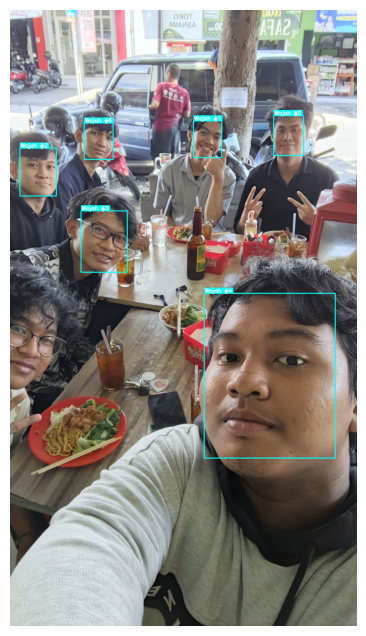

In [10]:
from google.colab import files
import matplotlib.pyplot as plt

# Upload Foto
print("Silakan upload foto yang ingin dideteksi wajahnya (JPG/PNG):")
uploaded = files.upload()

def process_static_image(image_path):
    # Baca Gambar
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"[ERROR] Gagal membaca gambar dari path: {image_path}")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    overlay_img = img_rgb.copy()

    # 1. Detection (MTCNN)
    detections = detector.detect_faces(img_rgb)

    if not detections:
        print(f"[INFO] Tidak ada wajah terdeteksi di {image_path}")
        plt.figure(figsize=(10, 8)) # Added figure size
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Tidak ada wajah terdeteksi di {os.path.basename(image_path)}") # Added title for clarity
        plt.show()
        return

    print(f"[INFO] Mendeteksi {len(detections)} wajah dalam foto...")
    h_img, w_img, _ = img_rgb.shape

    for i, detection in enumerate(detections):
        # MTCNN returns [x, y, width, height] in pixel coordinates
        x, y, w, h = detection['box']

        # Ensure coordinates are within image bounds
        x = max(0, x)
        y = max(0, y)
        w = min(w_img - x, w)
        h = min(h_img - y, h)

        # Padding (Sama seperti proses training/live)
        margin = 0.1 # 10%
        x1 = max(0, int(x - w * margin))
        y1 = max(0, int(y - h * margin))
        x2 = min(w_img, int(x + w + (w * margin)))
        y2 = min(h_img, int(y + h + (h * margin)))

        face_img = img_rgb[y1:y2, x1:x2]

        if face_img.size > 0:
            try:
                # 2. Resize ke Input Model (160x160)
                face_resized = cv2.resize(face_img, TARGET_SIZE)
                face_input = np.expand_dims(face_resized, axis=0)

                # 3. Embedding & Recognition
                vector = embedder.embeddings(face_input)[0]
                name, score = find_match(vector, database)

                # 4. Visualisasi (Matplotlib)
                # Define font parameters
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 1.2
                font_thickness = 4
                bbox_line_thickness = 5
                text_padding_x = 10
                text_padding_y = 10

                # Conditional labeling logic
                if len(detections) > 1:
                    color = (0, 255, 255) # Yellow for numbered faces
                    label_text = f"Wajah #{i+1}"
                    full_label = label_text # No score for numbered faces for simplicity
                else:
                    if name != "Unknown":
                        color = (0, 255, 0) # Green (Known)
                        label_text = f"{name}"
                    else:
                        color = (255, 0, 0) # Red (Unknown)
                        label_text = "Unknown"
                    # Text to display including accuracy
                    full_label = f"{label_text} ({score*100:.0f}%)"

                # Calculate text size for dynamic background
                (text_width, text_height), baseline = cv2.getTextSize(full_label, font, font_scale, font_thickness)

                # Draw Bounding Box
                cv2.rectangle(overlay_img, (x, y), (x + w, y + h), color, bbox_line_thickness)

                # Calculate proposed coordinates for the text background rectangle
                bg_x1 = x
                bg_y1_proposed = y - text_height - text_padding_y
                bg_x2_proposed = x + text_width + text_padding_x
                bg_y2 = y # Aligned with top of face bbox

                # Adjust background coordinates if they go out of image bounds
                bg_x2_final = min(w_img, bg_x2_proposed)

                # If the proposed background goes off the top, adjust it to start from y=0
                if bg_y1_proposed < 0:
                    bg_y1_final = 0
                    bg_y2_final = min(bg_y2, bg_y1_final + text_height + text_padding_y + baseline)
                    text_origin_x = bg_x1 + text_padding_x // 2
                    text_origin_y = bg_y1_final + text_height + text_padding_y // 2
                else:
                    bg_y1_final = bg_y1_proposed
                    bg_y2_final = bg_y2
                    text_origin_x = bg_x1 + text_padding_x // 2
                    text_origin_y = bg_y2_final - text_padding_y // 2

                # Draw Background for Text
                cv2.rectangle(overlay_img, (bg_x1, bg_y1_final), (bg_x2_final, bg_y2_final), color, -1)

                # Tulis Nama
                cv2.putText(overlay_img, full_label, (text_origin_x, text_origin_y),
                            font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

                print(f" > Wajah #{i+1}: Terdeteksi sebagai {name} (Akurasi: {score:.4f})")

            except Exception as e:
                print(f" > Wajah #{i+1}: Gagal diproses. Error: {e}")

    # Tampilkan Gambar Akhir
    plt.figure(figsize=(12, 8))
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.title(f"Hasil Deteksi Foto Upload: {os.path.basename(image_path)}")
    plt.show()

# Proses setiap file yang diupload
for filename in uploaded.keys():
    print(f"\nMemproses gambar: {filename}...")
    process_static_image(filename)